In [2]:
# from pathlib import Path
# import os, kagglehub

# project_root = Path.cwd()
# data_dir = project_root / "data"
# data_dir.mkdir(parents=True, exist_ok=True)

# os.environ["KAGGLEHUB_CACHE"] = str(data_dir)

# dataset_path = kagglehub.dataset_download("zlatan599/mushroom1")

# Benchmark: Training a CNN with the mushroom dataset

The base code was adopted from the pytorch tutorial for building an image classifier: https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Afterwards, these three tutorials from datacamp, topcoder and towardsscience were used to adapt the code and tune the hyperparameters.
- https://www.datacamp.com/tutorial/pytorch-cnn-tutorial?dc_referrer=https%3A%2F%2Fwww.google.com%2F
- https://www.topcoder.com/blog/image-classification-with-pytorch
- https://towardsdatascience.com/how-to-apply-a-cnn-from-pytorch-to-your-images-18515416bba1/

### Step 1: Check if GPU is available and set the device variable

In [ ]:
import torch, os
print("CUDA available:", torch.cuda.is_available())
print("CUDA version (torch):", torch.version.cuda)
print("device_count:", torch.cuda.device_count())
print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

### Step 2: Define a function __get_data()__ which uses PyTorch utilities for image datasets, transforms, and data loading.

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split

def get_transform_data():

    transform = transforms.Compose([
    transforms.Resize((256, 224)),
    transforms.ToTensor(),
])

    dataset = datasets.ImageFolder(
        root="archive/merged_dataset",
        transform=transform
    )

    N = len(dataset)

    train_size = int(0.8 * N)
    val_size   = int(0.1 * N)
    test_size  = N - train_size - val_size  # Rest for test

    train_data, val_data, test_data = random_split(
        dataset, [train_size, val_size, test_size]
    )

    print(len(dataset))
    print(len(train_data), len(val_data), len(test_data))

    train_data = DataLoader(train_data, batch_size=512, shuffle=True, num_workers=16, pin_memory=True, persistent_workers=True, prefetch_factor=4)
    val_data = DataLoader(val_data, batch_size=512, shuffle=False)
    test_data = DataLoader(test_data, batch_size=512, shuffle=False)


    return train_data, val_data, test_data

In [ ]:
train_data, val_data, test_data = get_transform_data()

### Step 3: Define the PyTorch CNN model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)

        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1 = nn.Linear(51728, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 169)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net = net.to(device)

### Step 4: Define Loss function and optimizer

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Step 4: Define a function for training the model

In [ ]:
import matplotlib.pyplot as plt

def train_net(n_epoch):
    losses = []
    for epoch in range(n_epoch):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(train_data, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            running_loss += loss.item()
            if i % 100 == 99:  # print every 2000 mini-batches
                print('[%d, %5d] loss: %.10f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    plt.plot(losses, label='Training loss')
    plt.xlabel("training steps")
    plt.ylabel("loss value")
    plt.show()
    print('Finished Training')
    return net

### Step 5: Define a function for evaluating the trained model

In [ ]:
def evaluate(net, test_loader, device):
    net.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = net(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100.0 * correct / total
    print(f"Accuracy on {total} test images: {acc:.2f}%")
    return acc


net = train_net(2)
evaluate(net, test_data, device)

### Documentation of the hyperparameter optimization process

#### Cycle 1: 
- transformations: Resize((256, 224))
- 2 Epochs

Result: 7% Accuracy

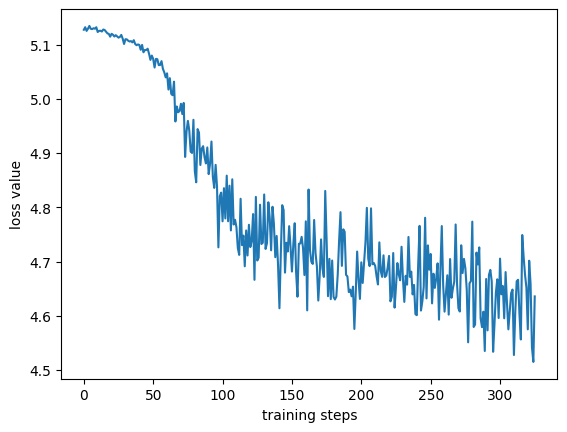

## Trying preprocessing and benchmarking scripts

In [3]:
from src.preprocessing import load_config
from src.preprocessing import get_data
from src.benchmark import run_benchmark
import matplotlib.pyplot as plt

/opt/homebrew/Caskroom/miniforge/base/envs/datascience/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
loaded_config = load_config()
loaded_data = get_data()

print(loaded_config)
print(loaded_data)

Total images: 104088
Split: Train(83270), Val(10408), Test(10410)
{'data': {'DATASET_PATH': 'CML/data/merged_dataset.nosync', 'IMAGE_SIZE': 224, 'BATCH_SIZE': 256, 'NUM_WORKERS': 12, 'PREFETCH_FACTOR': 4, 'TRAIN_RATIO': 0.8, 'VAL_RATIO': 0.1}, 'model': {'TYPE_BIOCLIP': 'hf-hub:imageomics/bioclip', 'TYPE_CLIP': None, 'MEAN': [0.48145466, 0.4578275, 0.40821073], 'STD': [0.26862954, 0.26130258, 0.27577711]}, 'hardware': {'HARDWAREDEVICE': 'mps'}}
(<torch.utils.data.dataloader.DataLoader object at 0x346fe9130>, <torch.utils.data.dataloader.DataLoader object at 0x34751de50>, <torch.utils.data.dataloader.DataLoader object at 0x34754cad0>)


## testing the benchmark scripts:

In [ ]:
acc_bioclip = run_benchmark('hf-hub:imageomics/bioclip')
print(acc_bioclip)

acc_openclip = run_benchmark('ViT-B-32', pretrained='laion2b_s34b_b79k')
print(acc_openclip)

Total images: 104088
Split: Train(83270), Val(10408), Test(10410)


Eval imageomics/bioclip: 100%|██████████| 41/41 [04:10<00:00,  6.11s/it, acc=77.61%]



 hf-hub:imageomics/bioclip Final Accuracy: 77.61%
77.60806916426513
Total images: 104088
Split: Train(83270), Val(10408), Test(10410)


Eval ViT-B-32: 100%|██████████| 41/41 [02:36<00:00,  3.82s/it, acc=9.64%]


 ViT-B-32 Final Accuracy: 9.64%
9.644572526416907


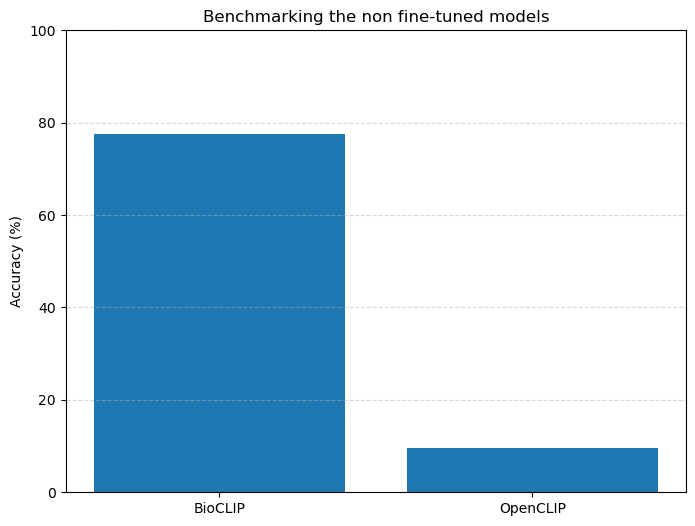

In [8]:
scores = {
    'BioCLIP': acc_bioclip,
    'OpenCLIP': acc_openclip
}

plt.figure(figsize=(8, 6))
plt.bar(scores.keys(), scores.values())
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Benchmarking the non fine-tuned models')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()